In [1]:
# : Imports & config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.decomposition import PCA

from processors import (
    RawFeatureGenerator,
    OptimizedFeatureGenerator,
    EntityEmbeddingFeatureGenerator,
)
from evaluator import RossmannComparer

plt.style.use("ggplot")
sns.set()


In [2]:
# : Load Rossmann data

train_df = pd.read_csv("data/train.csv", parse_dates=["Date"], low_memory=False)
store_df = pd.read_csv("data/store.csv")

train_df = train_df[(train_df["Sales"] > 0) & (train_df["Open"] == 1)].copy()
train_df = train_df.drop(columns='Customers')
train_df.head()


,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,1,1,0,1
1,2,5,2015-07-31,6064,1,1,0,1
2,3,5,2015-07-31,8314,1,1,0,1
3,4,5,2015-07-31,13995,1,1,0,1
4,5,5,2015-07-31,4822,1,1,0,1


<Figure size 1200x500 with 0 Axes>

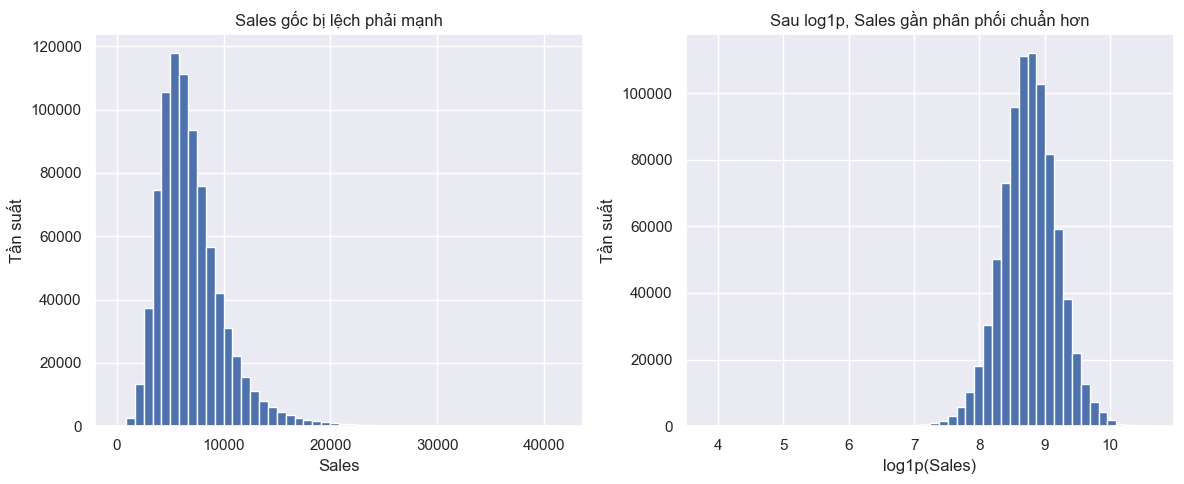

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo biến log
train_df_log_viz = train_df.copy()
train_df_log_viz["Sales_log"] = np.log1p(train_df_log_viz["Sales"])

plt.figure(figsize=(12, 5))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(train_df_log_viz["Sales"], bins=50)
axes[0].set_title("Sales gốc bị lệch phải mạnh")
axes[0].set_xlabel("Sales")
axes[0].set_ylabel("Tần suất")

axes[1].hist(train_df_log_viz["Sales_log"], bins=50)
axes[1].set_title("Sau log1p, Sales gần phân phối chuẩn hơn")
axes[1].set_xlabel("log1p(Sales)")
axes[1].set_ylabel("Tần suất")

plt.tight_layout()
plt.show()



In [4]:
# : Khởi tạo RossmannComparer và 3 pipeline (RAW / OPT / EMB)

FIXED_PARAMS = {
    'objective': 'reg:squarederror',
    'n_estimators': 300,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'n_jobs': -1,
    'random_state': 42
}

comparer = RossmannComparer(FIXED_PARAMS, train_df, store_df)

raw_proc = RawFeatureGenerator()
opt_proc  = OptimizedFeatureGenerator()
emb_proc  = EntityEmbeddingFeatureGenerator(
    model_save_path="checkpoints/emb_model_compare.pth",
    epochs=20,
    batch_size=256,
)

raw_proc, opt_proc, emb_proc


(RawFeatureGenerator(),
 OptimizedFeatureGenerator(),
 EntityEmbeddingFeatureGenerator(batch_size=256, epochs=20,
                                 model_save_path='checkpoints/emb_model_compare.pth'))

In [5]:
# : Evaluate 3 pipeline bằng XGBoost (log-target)

rmspe_raw = comparer.evaluate("RAW_LabelEncode", raw_proc, use_log_target=False)
rmspe_opt = comparer.evaluate("Optimized_FE",   opt_proc, use_log_target=True)
rmspe_emb = comparer.evaluate("EntityEmbedding", emb_proc, use_log_target=True)

summary = comparer.get_summary()
summary



--- Evaluating: RAW_LabelEncode ---
Preprocessing...
Training XGBoost (Log Target: False)...
Done. RMSPE: 0.16692

--- Evaluating: Optimized_FE ---
Preprocessing...
Training XGBoost (Log Target: True)...
Optimizing correction factor...
Best Factor: 0.98
Done. RMSPE: 0.14222

--- Evaluating: EntityEmbedding ---
Preprocessing...

[EntityEmbedding] 1. Feature Engineering (Train)...
[EntityEmbedding] 2. Computing Medians...
[EntityEmbedding] 3. Fitting Label Encoders...
[EntityEmbedding] 4. Scaling Continuous Variables...

[Embed Training] Device: cuda | Batch Size: 256
[Embed Training] Start training for 20 epochs...
  >> Epoch 1/20 | Loss (MSE): 2.38369
  >> Epoch 2/20 | Loss (MSE): 0.12907
  >> Epoch 3/20 | Loss (MSE): 0.07072
  >> Epoch 4/20 | Loss (MSE): 0.05527
  >> Epoch 5/20 | Loss (MSE): 0.05014
  >> Epoch 6/20 | Loss (MSE): 0.04653
  >> Epoch 7/20 | Loss (MSE): 0.04374
  >> Epoch 8/20 | Loss (MSE): 0.04128
  >> Epoch 9/20 | Loss (MSE): 0.03911
  >> Epoch 10/20 | Loss (MSE): 0.03

d:\dataviz_proj\processors.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_save_path, map_location=self.device))
d:\dataviz

Training XGBoost (Log Target: True)...
Optimizing correction factor...
Best Factor: 0.983
Done. RMSPE: 0.11848


,RMSPE,Features,Log Target
EntityEmbedding,0.118485,96,True
Optimized_FE,0.142221,22,True
RAW_LabelEncode,0.166923,17,False


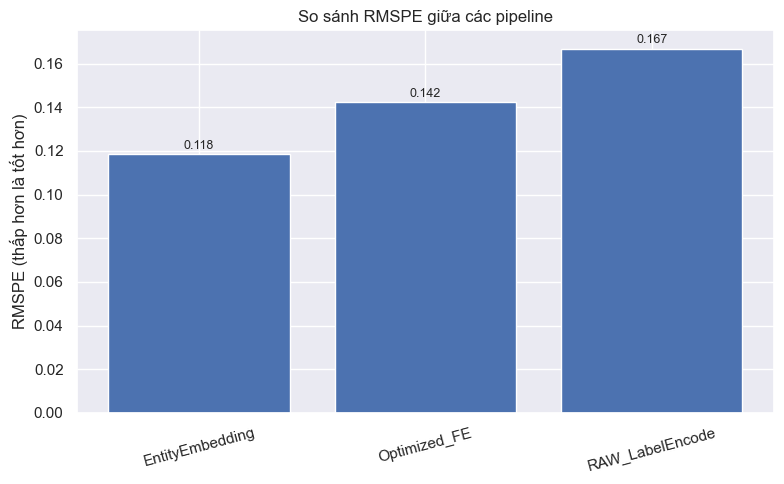

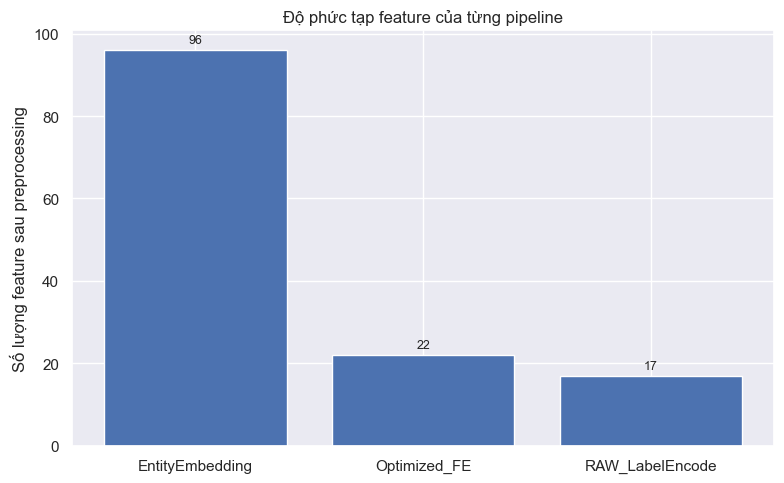

In [6]:
# : Bar chart so sánh RMSPE + số lượng feature

fig, ax1 = plt.subplots(figsize=(8, 5))

summary_plot = summary.copy()
pipelines = summary_plot.index.tolist()
x = np.arange(len(pipelines))

rmspe_vals = summary_plot["RMSPE"].values
feat_vals  = summary_plot["Features"].values

# Bar RMSPE
ax1.bar(x, rmspe_vals)
ax1.set_ylabel("RMSPE (thấp hơn là tốt hơn)")
ax1.set_xticks(x)
ax1.set_xticklabels(pipelines, rotation=15)
ax1.set_title("So sánh RMSPE giữa các pipeline")

for i, v in enumerate(rmspe_vals):
    ax1.text(x[i], v + 0.001, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Bar số feature
fig, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar(pipelines, feat_vals)
ax2.set_ylabel("Số lượng feature sau preprocessing")
ax2.set_title("Độ phức tạp feature của từng pipeline")

for i, v in enumerate(feat_vals):
    ax2.text(i, v + 1, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [7]:
# : Tạo dataframe feature từ OptimizedFeatureGenerator để vẽ EDA

# comparer.full_data = train_df merge với store_df
opt_features = opt_proc.transform(comparer.full_data.copy())

# Đảm bảo có cột Sales để vẽ
opt_features["Sales"] = comparer.full_data["Sales"].values

opt_features.head()


,Store,DayOfWeek,Sales,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Year,Month,Day,WeekOfYear,WeekOfMonth,IsWeekend,IsStateHoliday,CompetitionMonthsOpen,Promo2Weeks,IsPromo2Month
0,1,5,5263,1,1,2,0,1270.0,9,2008,...,2015,7,31,31,5,0,0,82,0,0
1,2,5,6064,1,1,0,0,570.0,11,2007,...,2015,7,31,31,5,0,0,92,278,1
2,3,5,8314,1,1,0,0,14130.0,12,2006,...,2015,7,31,31,5,0,0,103,225,1
3,4,5,13995,1,1,2,2,620.0,9,2009,...,2015,7,31,31,5,0,0,70,0,0
4,5,5,4822,1,1,0,0,29910.0,4,2015,...,2015,7,31,31,5,0,0,3,0,0


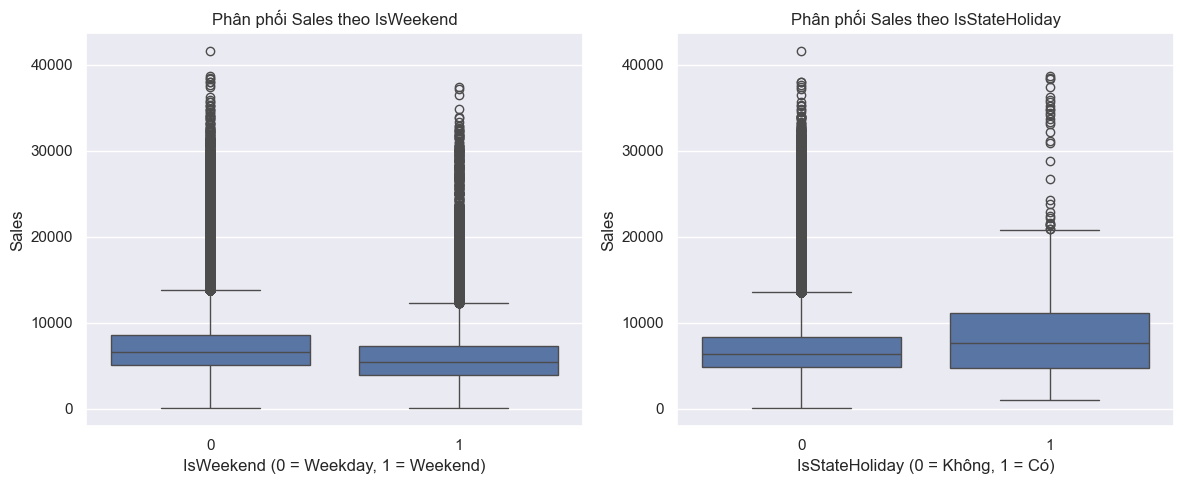

In [8]:
# : Boxplot Sales theo IsWeekend và IsStateHoliday (pipeline Optimized_FE)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=opt_features, x="IsWeekend", y="Sales", ax=axes[0])
axes[0].set_title("Phân phối Sales theo IsWeekend")
axes[0].set_xlabel("IsWeekend (0 = Weekday, 1 = Weekend)")

sns.boxplot(data=opt_features, x="IsStateHoliday", y="Sales", ax=axes[1])
axes[1].set_title("Phân phối Sales theo IsStateHoliday")
axes[1].set_xlabel("IsStateHoliday (0 = Không, 1 = Có)")

plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_7224\1659725335.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Promo2Weeks_bin")["Sales"]


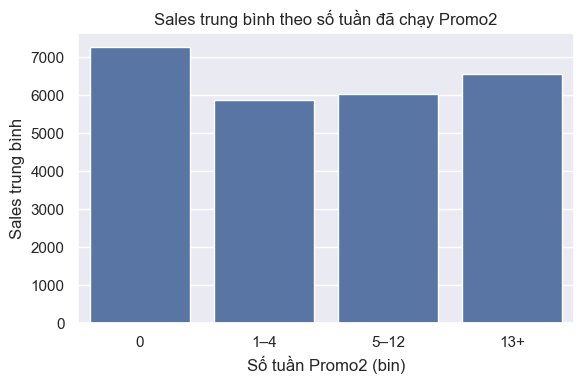

In [9]:
# : Barplot Sales trung bình theo Promo2Weeks (bin)

opt_features["Promo2Weeks_bin"] = pd.cut(
    opt_features["Promo2Weeks"],
    bins=[-1, 0, 4, 12, opt_features["Promo2Weeks"].max()],
    labels=["0", "1–4", "5–12", "13+"]
)

promo_group = (
    opt_features
    .groupby("Promo2Weeks_bin")["Sales"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=promo_group, x="Promo2Weeks_bin", y="Sales")
plt.title("Sales trung bình theo số tuần đã chạy Promo2")
plt.xlabel("Số tuần Promo2 (bin)")
plt.ylabel("Sales trung bình")
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_7224\1715348506.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("CompetitionMonthsOpen_bin")["Sales"]


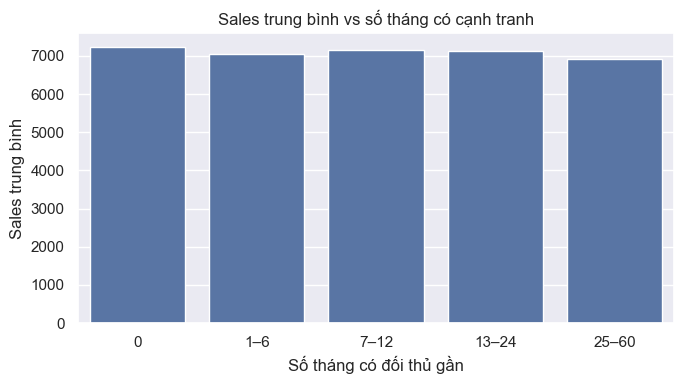

In [10]:
# : Barplot Sales theo CompetitionMonthsOpen (bin)

opt_features["CompetitionMonthsOpen_bin"] = pd.cut(
    opt_features["CompetitionMonthsOpen"],
    bins=[-1, 0, 6, 12, 24, 60],
    labels=["0", "1–6", "7–12", "13–24", "25–60"]
)

comp_group = (
    opt_features
    .groupby("CompetitionMonthsOpen_bin")["Sales"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7, 4))
sns.barplot(data=comp_group, x="CompetitionMonthsOpen_bin", y="Sales")
plt.title("Sales trung bình vs số tháng có cạnh tranh")
plt.xlabel("Số tháng có đối thủ gần")
plt.ylabel("Sales trung bình")
plt.tight_layout()
plt.show()


In [12]:
# : Hàm load model embedding đã train từ emb_proc
from models import EntityEmbeddingModel

def load_trained_embedding_model(emb_processor: EntityEmbeddingFeatureGenerator) -> EntityEmbeddingModel:
    model = EntityEmbeddingModel(
        emb_processor.emb_dims,
        n_cont=len(emb_processor.cont_cols)
    )
    state_dict = torch.load(
        emb_processor.model_save_path,
        map_location=emb_processor.device
    )
    model.load_state_dict(state_dict)
    model.eval()
    return model

model_emb = load_trained_embedding_model(emb_proc)
model_emb


C:\Users\Admin\AppData\Local\Temp\ipykernel_7224\1369910547.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


EntityEmbeddingModel(
  (embeddings): ModuleList(
    (0): Embedding(1115, 50)
    (1): Embedding(7, 4)
    (2): Embedding(3, 2)
    (3): Embedding(12, 6)
    (4): Embedding(31, 16)
    (5-6): 2 x Embedding(4, 2)
    (7): Embedding(3, 2)
    (8): Embedding(4, 2)
    (9): Embedding(5, 3)
  )
  (fc1): Linear(in_features=96, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

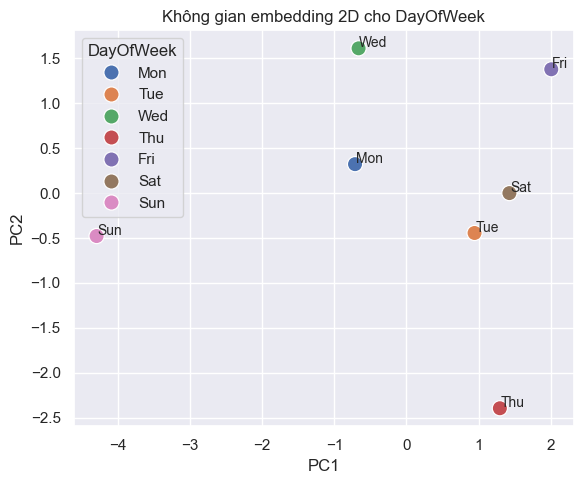

In [13]:
# : PCA 2D cho embedding DayOfWeek

day_idx = emb_proc.cat_cols.index("DayOfWeek")
W_day   = model_emb.embeddings[day_idx].weight.detach().cpu().numpy()  # (n_days, dim)

# Lấy nhãn gốc từ LabelEncoder (string "0","1",..., "6")
le_day      = emb_proc.label_encoders["DayOfWeek"]
day_labels  = le_day.classes_.astype(int)  # -> 0..6
day_name_map = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
day_names   = pd.Series(day_labels).map(day_name_map).values

pca = PCA(n_components=2)
coords_day = pca.fit_transform(W_day)

emb_day_df = pd.DataFrame({
    "PC1": coords_day[:, 0],
    "PC2": coords_day[:, 1],
    "DayInt": day_labels,
    "DayName": day_names,
})

plt.figure(figsize=(6, 5))
sns.scatterplot(data=emb_day_df, x="PC1", y="PC2", hue="DayName", s=120)

for _, row in emb_day_df.iterrows():
    plt.text(row["PC1"] + 0.01, row["PC2"] + 0.01, row["DayName"], fontsize=10)

plt.title("Không gian embedding 2D cho DayOfWeek")
plt.legend(title="DayOfWeek")
plt.tight_layout()
plt.show()


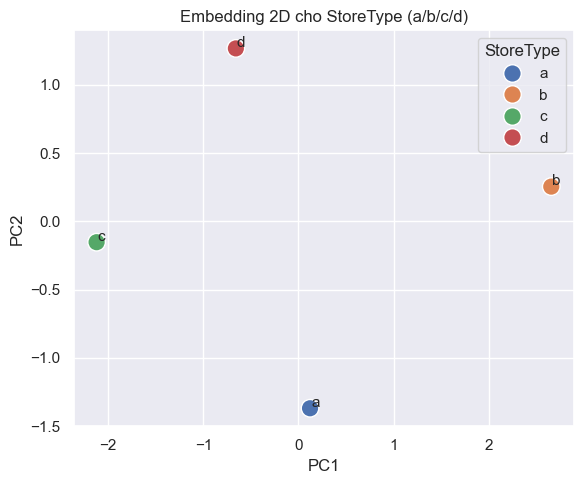

In [14]:
# : PCA 2D cho embedding StoreType

stype_idx = emb_proc.cat_cols.index("StoreType")
W_stype   = model_emb.embeddings[stype_idx].weight.detach().cpu().numpy()

le_stype      = emb_proc.label_encoders["StoreType"]
stype_labels  = le_stype.classes_  # thường là ["a","b","c","d"]

coords_stype = pca.fit_transform(W_stype)

emb_stype_df = pd.DataFrame({
    "PC1": coords_stype[:, 0],
    "PC2": coords_stype[:, 1],
    "StoreType": stype_labels,
})

plt.figure(figsize=(6, 5))
sns.scatterplot(data=emb_stype_df, x="PC1", y="PC2", hue="StoreType", s=160)

for _, row in emb_stype_df.iterrows():
    plt.text(row["PC1"] + 0.01, row["PC2"] + 0.01, row["StoreType"], fontsize=11)

plt.title("Embedding 2D cho StoreType (a/b/c/d)")
plt.legend(title="StoreType")
plt.tight_layout()
plt.show()


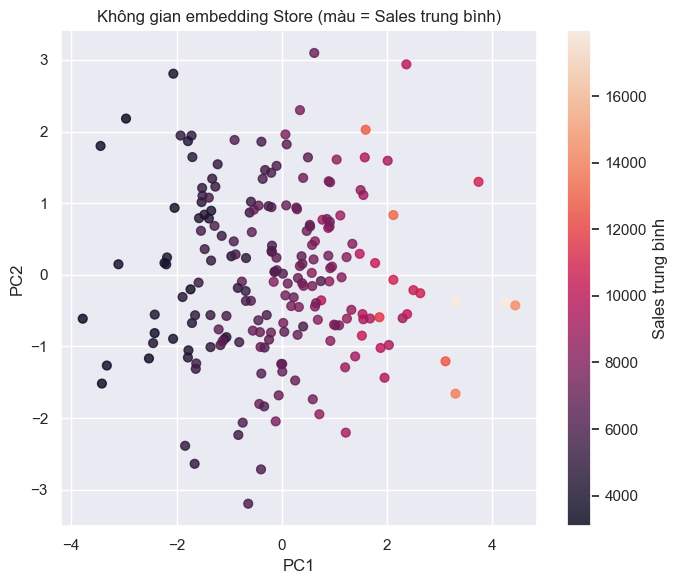

In [15]:
# : Không gian embedding Store, màu = Sales trung bình

store_idx = emb_proc.cat_cols.index("Store")
W_store   = model_emb.embeddings[store_idx].weight.detach().cpu().numpy()

le_store   = emb_proc.label_encoders["Store"]
store_ids  = le_store.classes_.astype(int)  # số hiệu cửa hàng

pca_store   = PCA(n_components=2)
coords_store = pca_store.fit_transform(W_store)

emb_store_df = pd.DataFrame({
    "PC1": coords_store[:, 0],
    "PC2": coords_store[:, 1],
    "Store": store_ids,
})

# Thêm Sales trung bình theo store
mean_sales = comparer.full_data.groupby("Store")["Sales"].mean()
emb_store_df = emb_store_df.merge(mean_sales, on="Store", how="left")

# Chỉ vẽ ngẫu nhiên 200 store để plot cho đỡ rối
plot_df = emb_store_df.sample(n=min(200, len(emb_store_df)), random_state=42)

plt.figure(figsize=(7, 6))
sc = plt.scatter(
    plot_df["PC1"],
    plot_df["PC2"],
    c=plot_df["Sales"],
    s=40,
    alpha=0.8,
)
plt.colorbar(sc, label="Sales trung bình")
plt.title("Không gian embedding Store (màu = Sales trung bình)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


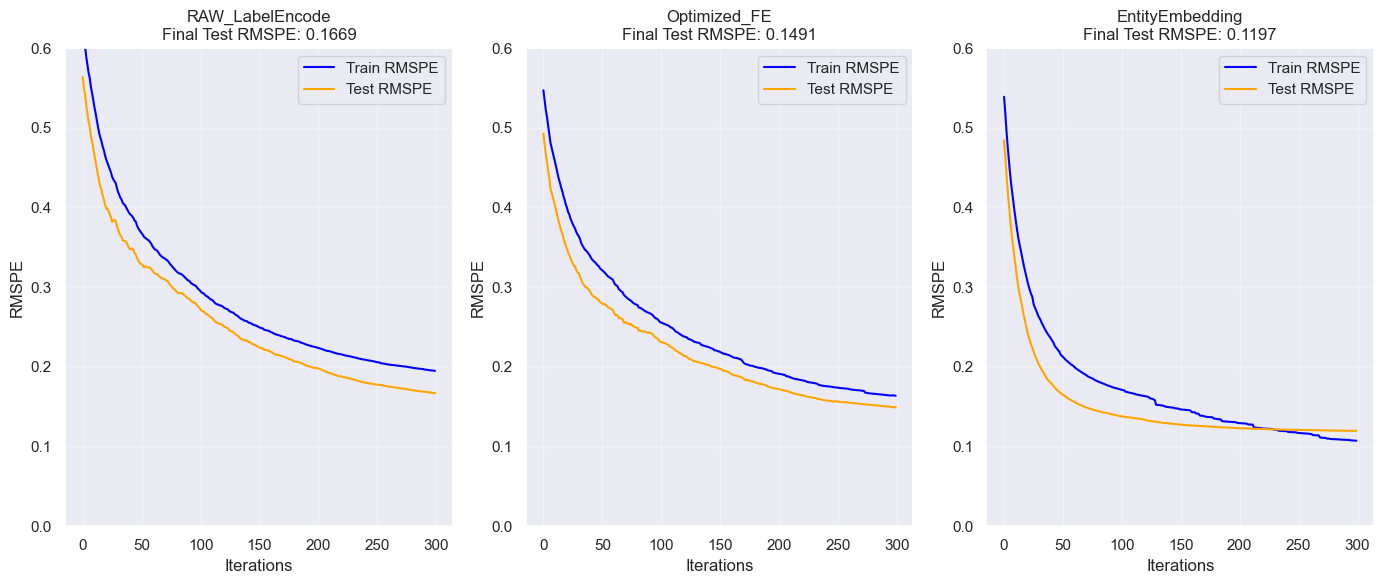

In [16]:
#Learning curves Train/Test RMSPE cho từng pipeline

comparer.plot_learning_curves()


In [17]:
# Lấy embedding matrix cho từng categorical từ model đã train

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use("ggplot")
sns.set()

# model_emb & emb_proc đã có từ trước (Cell load_trained_embedding_model)
cat_to_W = {}
for i, col in enumerate(emb_proc.cat_cols):
    W = model_emb.embeddings[i].weight.detach().cpu().numpy()
    cat_to_W[col] = W

cat_to_W.keys()


dict_keys(['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'WeekOfMonth'])

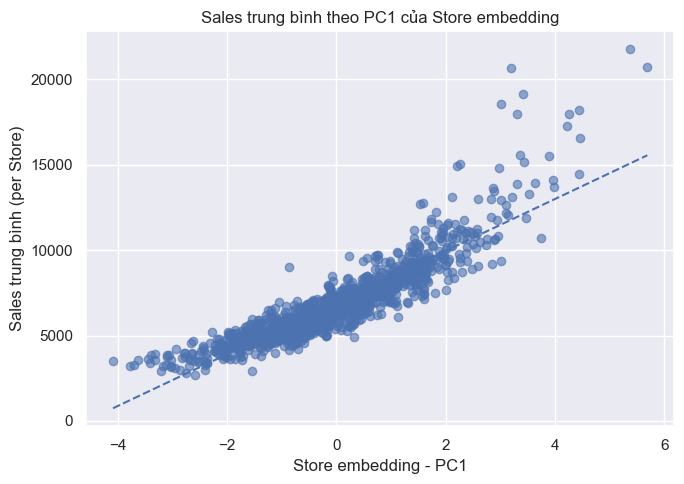

In [18]:
# : Quan hệ giữa Sales trung bình và PC1 của Store embedding

pca_store = PCA(n_components=4)
store_pcs = pca_store.fit_transform(W_store)  

pc_df = pd.DataFrame({
    "Store": store_ids,
    "PC1": store_pcs[:, 0],
    "PC2": store_pcs[:, 1],
})
pc_df = pc_df.merge(mean_sales.rename("MeanSales"), on="Store", how="left")

plt.figure(figsize=(7, 5))
plt.scatter(pc_df["PC1"], pc_df["MeanSales"], alpha=0.6)
plt.xlabel("Store embedding - PC1")
plt.ylabel("Sales trung bình (per Store)")
plt.title("Sales trung bình theo PC1 của Store embedding")

# fit đường xu hướng tuyến tính cho đẹp
coef = np.polyfit(pc_df["PC1"], pc_df["MeanSales"], deg=1)
x_line = np.linspace(pc_df["PC1"].min(), pc_df["PC1"].max(), 100)
y_line = coef[0] * x_line + coef[1]
plt.plot(x_line, y_line, linestyle="--")

plt.tight_layout()
plt.show()


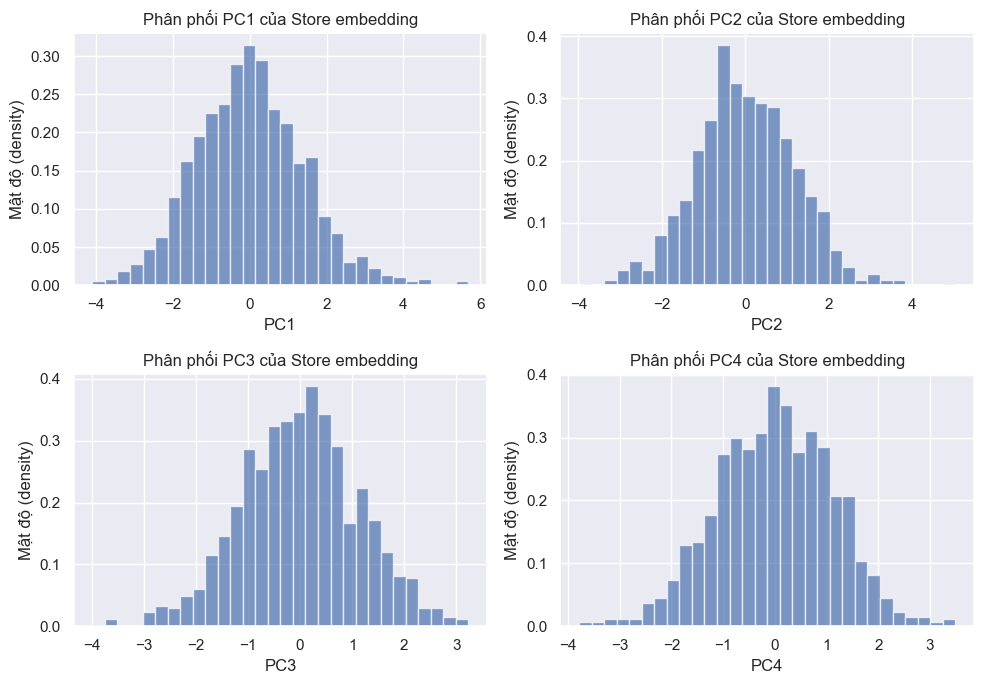

In [19]:
# : Histogram mật độ PC1–PC4 của Store embedding

fig, axes = plt.subplots(2, 2, figsize=(10, 7))

for i in range(4):
    ax = axes.flat[i]
    ax.hist(store_pcs[:, i], bins=30, density=True, alpha=0.7)
    ax.set_title(f"Phân phối PC{i+1} của Store embedding")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel("Mật độ (density)")

plt.tight_layout()
plt.show()


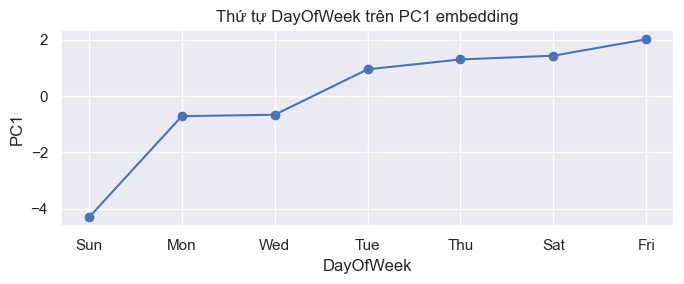

,DayInt,PC1,DayName
6,6,-4.296541,Sun
0,0,-0.713257,Mon
2,2,-0.664042,Wed
1,1,0.944124,Tue
3,3,1.294991,Thu
5,5,1.427108,Sat
4,4,2.007617,Fri


In [20]:
# : Thứ tự DayOfWeek trong không gian embedding

W_dow = cat_to_W["DayOfWeek"]
le_dow = emb_proc.label_encoders["DayOfWeek"]
dow_labels = le_dow.classes_.astype(int)   # 0..6

# Lấy PC1 của embedding DayOfWeek (7 điểm)
pca_dow = PCA(n_components=1)
dow_pc1 = pca_dow.fit_transform(W_dow).flatten()

dow_df = pd.DataFrame({
    "DayInt": dow_labels,
    "PC1": dow_pc1,
})

day_name_map = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
dow_df["DayName"] = dow_df["DayInt"].map(day_name_map)

dow_df = dow_df.sort_values("PC1")

plt.figure(figsize=(7, 3))
plt.plot(dow_df["DayName"], dow_df["PC1"], marker="o")
plt.title("Thứ tự DayOfWeek trên PC1 embedding")
plt.xlabel("DayOfWeek")
plt.ylabel("PC1")
plt.tight_layout()
plt.show()

dow_df


Embedding Store shape: (1115, 50), #stores = 1115
log_mean_sales range: 7.902759801285105 -> 9.987759002693922
Số cặp dùng để vẽ: 99915
metric_dists range: 3.385311504899846e-06 -> 2.0020292440942127
embed_dists  range: 5.579919 -> 15.125086
corr(metric, embed): 0.3928480197802097


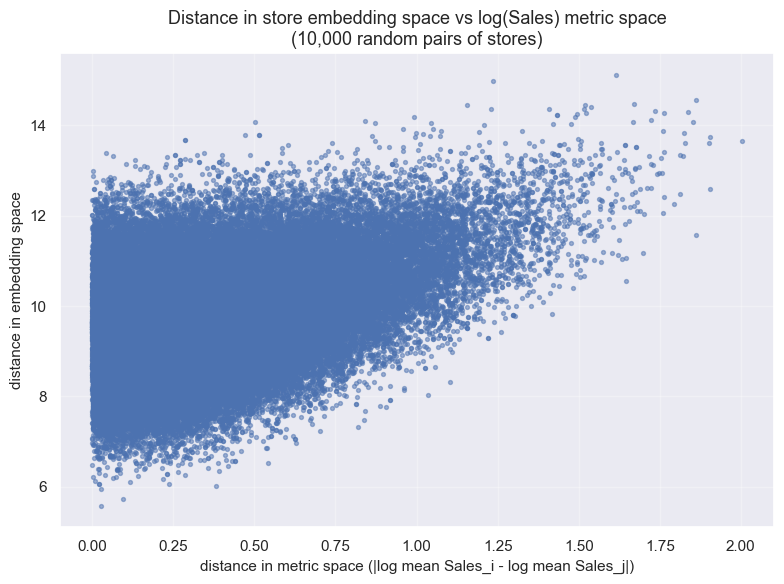

In [21]:
# Cell: Distance in metric space (log Sales) vs distance in embedding space

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# 1. Lấy embedding và thứ tự store bên trong embedding
store_idx = emb_proc.cat_cols.index("Store")
W_store   = model_emb.embeddings[store_idx].weight.detach().cpu().numpy()  # (n_stores, emb_dim)

le_store  = emb_proc.label_encoders["Store"]
store_ids = le_store.classes_.astype(int)   # ID Store gốc tương ứng với từng hàng trong W_store

n_stores, emb_dim = W_store.shape
print(f"Embedding Store shape: {W_store.shape}, #stores = {n_stores}")

# 2. Tính metric value = log1p(mean Sales) per Store
mean_sales = comparer.full_data.groupby("Store")["Sales"].mean()
log_mean_sales = np.log1p(mean_sales)   # thu nhỏ thang đo

# Sắp xếp metric theo đúng thứ tự store_ids (khớp với W_store)
log_metric_vals = log_mean_sales.loc[store_ids].values  # shape (n_stores,)

print("log_mean_sales range:", log_metric_vals.min(), "->", log_metric_vals.max())

# 3. Lấy 10 000 cặp store ngẫu nhiên & tính khoảng cách
N_PAIRS = 100_000
rng = np.random.default_rng(42)

i_idx = rng.integers(0, n_stores, size=N_PAIRS)
j_idx = rng.integers(0, n_stores, size=N_PAIRS)

mask = i_idx != j_idx
i_idx = i_idx[mask]
j_idx = j_idx[mask]
print("Số cặp dùng để vẽ:", len(i_idx))

# distance trong metric space = |log_sales_i - log_sales_j|
metric_dists = np.abs(log_metric_vals[i_idx] - log_metric_vals[j_idx])

# distance trong embedding space = ||e_i - e_j||_2
embed_dists = np.linalg.norm(W_store[i_idx] - W_store[j_idx], axis=1)

print("metric_dists range:", metric_dists.min(), "->", metric_dists.max())
print("embed_dists  range:", embed_dists.min(), "->", embed_dists.max())
print("corr(metric, embed):", np.corrcoef(metric_dists, embed_dists)[0, 1])

# 4. Vẽ scatter giống Fig.2 (x = metric, y = embedding)
plt.figure(figsize=(8, 6))
plt.scatter(metric_dists, embed_dists, s=8, alpha=0.5)

plt.xlabel("distance in metric space (|log mean Sales_i - log mean Sales_j|)", fontsize=11)
plt.ylabel("distance in embedding space", fontsize=11)
plt.title("Distance in store embedding space vs log(Sales) metric space\n(10,000 random pairs of stores)",
          fontsize=13)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
